# <span style="color:orange">Image segmentation - Exercise </span>

<a href="https://colab.research.google.com/github/datarootsio/workshop-image-segmentation-style-transfer/blob/main/notebooks/exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to this image segmentation excercise. If you haven't followed the tutorial yet, we recommend that you do the tutorial first before completing this excercise. This is an exercise to get familiar with tool for image segmentation and style transfer. 

<span style="color:red">IMPORTANT INSTRUCTIONS: </span>
Please make a copy of this notebook, upload it into your own google drive.

If you decided to open this notebook without cloning the entire GitHub repository, please make sure to upload all the needed files manually. 

![Maintainer](https://dataroots.io/maintained-rnd.svg)

# 1 Objectives

The final objective of this exercise is to personalize a frame that is hanging on the wall in Dataroots' office. To do this, you will have to apply a style of your choice to make the frame more beautiful. However, we do not give you an image containing only the content of the frame to be personalized. Indeed, your original image is a picture of the Dataroots' office. It is up to you to create a model to detect the frame and apply your best style to this object!


In other words, the goal of this exercise session is to learn how to train a new image segmentation model capable of detecting frames on a picture instead of sofas. You might think that all you have to do is change the class of the object to be detected from "sofa" to "frame". Unfortunately, it's not as simple as that. 

## Install useful packages

Before installing useful packages, make sure you are using GPU runtime. To be sure that the GPU device is detected, run the following cell.

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


We need to install a specific version for each python packages that will be used in this exercise session. We first pipe all these useful packages into a requirements.txt file before installing them. This step can take several minutes to run.

In [1]:
!printf 'opencv-python \ntorch==1.8.0 \ntorchvision==0.9.0 \ncolormap \nipympl \neasydev \nopencv-contrib-python \npillow \nnumpy \nscipy \ntqdm \nmatplotlib==3.1.1 \nipykernel \nazureml-core \nazureml-dataprep \ntensorflow==2.2 \nkeras==2.3.1 \nazure-cli' > requirements.txt

In [2]:
!pip install -q -r requirements.txt
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

     |████████████████████████████████| 735.5 MB 14 kB/s 
     |████████████████████████████████| 17.3 MB 20.9 MB/s 
     |████████████████████████████████| 508 kB 59.1 MB/s 
     |████████████████████████████████| 47 kB 5.2 MB/s 
     |████████████████████████████████| 13.1 MB 27.3 MB/s 
     |████████████████████████████████| 2.7 MB 50.0 MB/s 
     |████████████████████████████████| 43.4 MB 1.3 MB/s 
     |████████████████████████████████| 516.2 MB 4.8 kB/s 
     |████████████████████████████████| 377 kB 75.8 MB/s 
     |████████████████████████████████| 2.6 MB 61.8 MB/s 
     |████████████████████████████████| 454 kB 75.5 MB/s 
     |████████████████████████████████| 3.0 MB 62.7 MB/s 
     |████████████████████████████████| 2.9 MB 62.5 MB/s 
     |████████████████████████████████| 26.1 MB 1.2 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 508 kB 70.1 MB/s 
     |████████████████████████████████| 507 kB 77.1 MB/s 
     |█████████

After the installation of all useful packages that will be used in this exercise session, please restart the runtime to be sure that everything is installed properly.

## Connect to Azure Blob

For ease of access, we have stored the data in the cloud (Azure). 
Before being able to access data from an Azure Blob storage, you first need to login into Azure using the following command. 

Please click on the link that appears after having ran the cell and enter the code to be able to login with your personnal account.

In [ ]:
!az login

Now that you are connected to Azure with your personnal account, you can access the Blob containing the data.

In [2]:
!git clone https://github.com/datarootsio/workshop-image-segmentation-style-transfer.git

Cloning into 'workshop-image-segmentation-style-transfer'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 39 (delta 15), reused 25 (delta 8), pack-reused 0
Unpacking objects: 100% (39/39), done.


If the following cell fails, it means that you probably forgot to restart the runtime before running it.

In [3]:
import azureml.core
from azureml.core import Workspace

ws = Workspace.from_config('./workshop-image-segmentation-style-transfer/config.json')
default_ds = ws.get_default_datastore()
print('Ready to use Azure ML {} to work with {} (datastore = {})'.format(
        azureml.core.VERSION, ws.name,default_ds.name))
ds = ws.datasets['all']
mount_ds = ds.mount()
ds_mount_folder = mount_ds.mount_point

DATA_DIR = ds_mount_folder
mount_ds.start()
print("You have access to the Azure Blob!")

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Ready to use Azure ML 1.44.0 to work with ml-homedesign (datastore = images_data)
Volume mount is not enabled. 
Falling back to dataflow mount.
Unrecognized authentication type: None
You have access to the Azure Blob!


# 2 How to create the new dataset set?

In the tutorial, we used a dataset that had already been sorted. Indeed, all the images contained a sofa since the objective was to detect this object. In this exercise session, the new objective is to detect frames rather than sofas on the same dataset. 

The dataset used contains annotations, which allow us to categorize the objects easily. Let's look at what these annotations look like and whether we can use them to detect frames. 

## 2.1 Load annotations relative to training set

The annotations are contained in a file in json format. Let's load the annotation file relative to the training set and observe the categories of objects that can be detected using this dataset. Small reminder: the dataset contains images of indoor virtual spaces.

In [3]:
import os
import json
from pycocotools.coco import COCO
import numpy as np

annotation_file = os.path.join(DATA_DIR, "train/train.json")

with open(annotation_file) as json_data:
        annotations = json.load(json_data)
        cats = annotations["categories"]
        categories = np.unique(np.array([cat["supercategory"] for cat in cats]))
        print("Categories of objects that can be detected: \n", categories)

Unrecognized authentication type: None
Unrecognized authentication type: None
Categories of objects that can be detected: 
 ['Barstool' 'Bed Frame' 'Bookcase / jewelry Armoire' 'Bunk Bed'
 'Ceiling Lamp' 'Chaise Longue Sofa' 'Children Cabinet'
 'Classic Chinese Chair' 'Coffee Table' 'Corner/Side Table' 'Desk'
 'Dining Chair' 'Dining Table' 'Drawer Chest / Corner cabinet'
 'Dressing Chair' 'Dressing Table'
 'Footstool / Sofastool / Bed End Stool / Stool' 'Kids Bed'
 'King-size Bed' 'L-shaped Sofa' 'Lazy Sofa'
 'Lounge Chair / Cafe Chair / Office Chair' 'Loveseat Sofa' 'Nightstand'
 'Pendant Lamp' 'Round End Table' 'Shelf'
 'Sideboard / Side Cabinet / Console table' 'Single bed' 'TV Stand'
 'Three-seat / Multi-seat Sofa' 'Wardrobe' 'Wine Cabinet' 'armchair']


We observe that there is no category for frames in the annotations of the dataset we used. We are therefore faced with a major problem: the frames category is not represented in the COCO dataset, so our dataset does not contain labeled examples for frames.

## 2.2 Let's try to detect frames using Mask RCNN

We saw in the previous section that the "frame" category is not represented in the COCO dataset. In order to verify this information and to visually observe that an object detection model pre-trained on the coco dataset is not able to detect frames, we will try to detect frames using [Mask RCNN](https://github.com/matterport/Mask_RCNN.git).

You first have to clone the repository containing the code to run.

In [6]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 39.13 MiB/s, done.
Resolving deltas: 100% (558/558), done.


Let's install some useful packages to be able to run this notebook.

In [8]:
!printf '\nnumpy \nscipy \npillow \ncython \nmatplotlib \nscikit-image \nopencv-python \nh5py \nimgaug \nIPython' > requirements.txt

In [9]:
!pip install -q -r requirements.txt
!pip install tensorflow==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 1.4 MB/s 
     |████████████████████████████████| 488 kB 58.5 MB/s 
     |████████████████████████████████| 3.1 MB 64.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kap

In [10]:
%cd Mask_RCNN/samples

/content/Mask_RCNN/samples


In [11]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version


Using TensorFlow backend.


In [12]:
import coco

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

... done downloading pretrained model!


In [13]:
 class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [15]:
import warnings
warnings.filterwarnings("ignore")

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

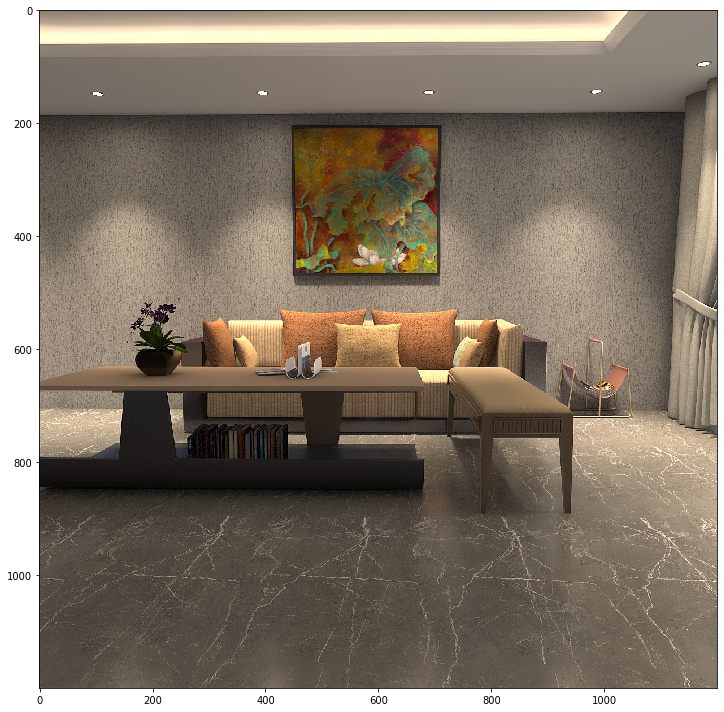

In [16]:
# Load a random image from the images folder
path_example = os.path.join(os.path.join(DATA_DIR, 'train/image'), "0000016.jpg")
image = skimage.io.imread(path_example)

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

Processing 1 images
image                    shape: (1200, 1200, 3)       min:    0.00000  max:  255.00000  uint8


molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


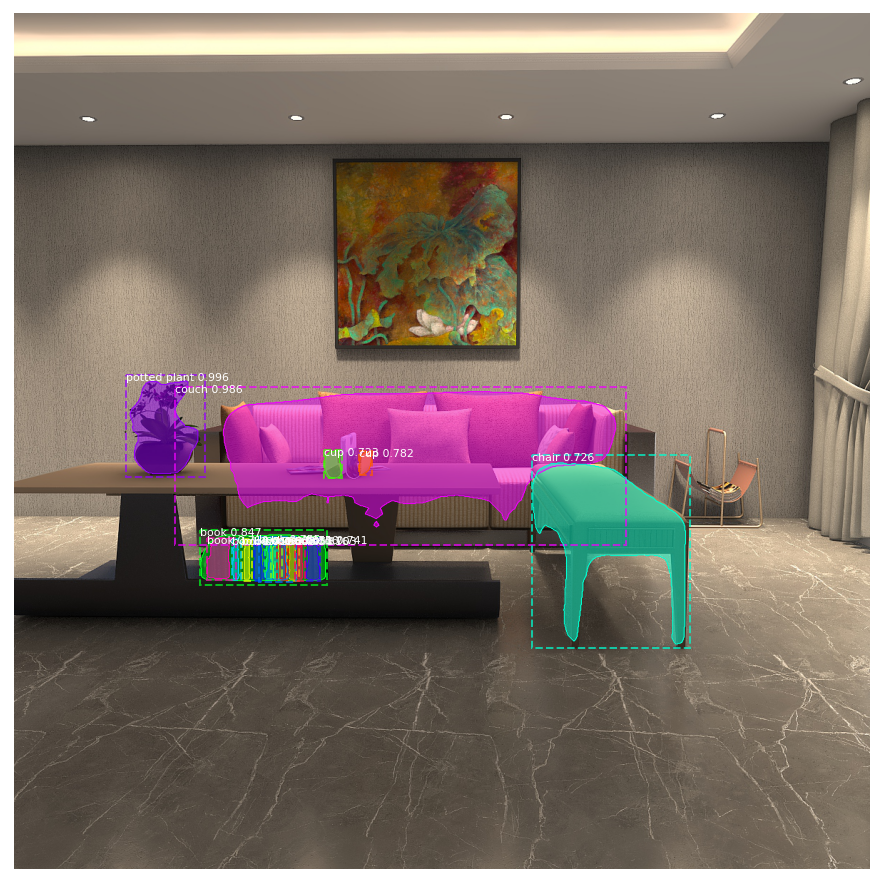

In [17]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

We observe that the model is not able to detect the frame on the image. We must therefore find a way to label the frames in order to train our new image segmentation model.

In the next sections, we will try to find a way to label our data in order to be able to train a ML model afterwards.

## 2.3 Solution 1: create the dataset manually using OpenCV

[OpenCV](https://opencv.org/about/) is a well-known open-source computer vision library that you can use very easily. 

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

In [8]:
import os, itertools
import matplotlib.pyplot as plt

def list_files(path_blob):
    images_dir = os.path.join(DATA_DIR, path_blob)
    list_elem = os.listdir(images_dir) 
    number_files = len(list_elem)
    print(f"Number of files in the {path_blob} folder: {number_files}")
    return list_elem, number_files


# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()

In [9]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import IPython.display as Disp
from ipywidgets import widgets
import numpy as np
import cv2

class bbox_select():

    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)

    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),2)
        return img

    def onclick(self, event):
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            pts = np.array(self.selected_points, np.int32)
            pts = pts.reshape((-1,1,2))
            cv2.polylines(self.im.copy(),[pts],True,(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)),3)


In [5]:
path_blob_images = 'train/image'
list_images, _ = list_files(path_blob=path_blob_images)

Number of files in the train/image folder: 14761


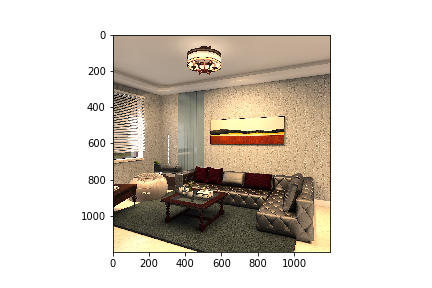

In [10]:
%matplotlib ipympl
from PIL import Image
import numpy as np
import os

image_dir = os.path.join(DATA_DIR, path_blob_images)

index = 4
path_image = list_images[index]

im = plt.imread(os.path.join(image_dir, path_image))
bs = bbox_select(im)

In [11]:
bs.selected_points

[[531.0673289183222, 465.5044150110376],
 [542.1048565121413, 592.4359823399559],
 [939.4558498896246, 608.9922737306844],
 [933.937086092715, 448.94812362030916]]

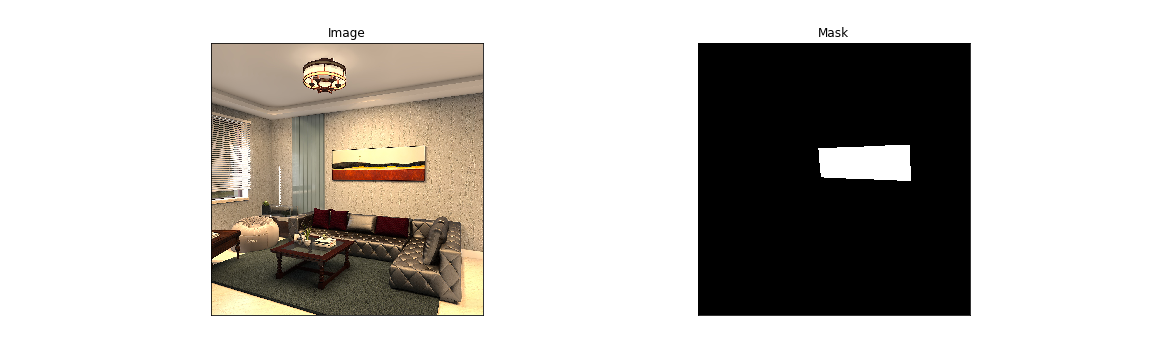

In [12]:
%matplotlib inline
arr = np.array([bs.selected_points],'int')
mask = cv2.fillPoly(np.zeros(im.shape, np.uint8), pts=arr, color=[255, 255, 255])

visualize(
    image=im,
    mask=mask
)

## 2.4 Solution 2: create the  dataset manually using idmap images

In this solution, we will try to find the mask of an object on an image according to the idmap of this image. 

In [13]:
path_blob_images = 'train/image'
path_blob_idmap = 'train/idmap'
list_images, _ = list_files(path_blob=path_blob_images)
list_idmap, _ = list_files(path_blob=path_blob_idmap)
count = 0

Number of files in the train/image folder: 14761
Number of files in the train/idmap folder: 14761


### Visualize images from the original dataset

Let's first have a look at the original image and the corresponding idmap.

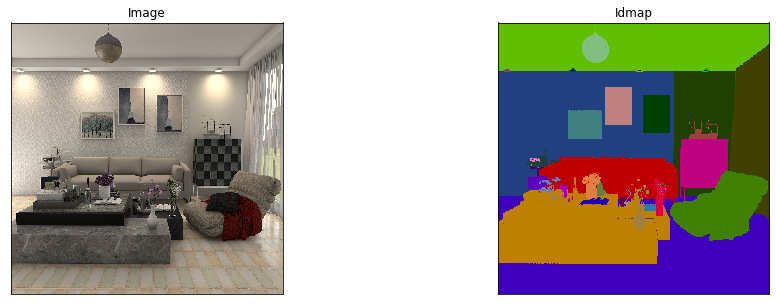

In [20]:
%matplotlib inline
from PIL import Image
import numpy as np
import os

image_dir = os.path.join(DATA_DIR, path_blob_images)
idmap_dir = os.path.join(DATA_DIR, path_blob_idmap)

index = 49
path_image = list_images[index]
path_idmap = list_idmap[index]

img = Image.open(os.path.join(image_dir, path_image))
idmap = Image.open(os.path.join(idmap_dir, path_idmap))

visualize(
    image=img, 
    idmap=idmap
)

### Identify colors from the idmap

In order to identify the frames on the picture, we will identify which color is representing a frame on the picture. In this case, you see 3 different frames represented by 3 different colors: 
- light blue
- light pink
- dark green

In [21]:
from typing import List
import pandas as pd
from colormap import rgb2hex

def from_rgb_to_hex(rgb_colors):
    #hex_colors = {}
    hex_colors = []
    for (occurences, rgb) in rgb_colors:
      #hex_colors[rgb2hex(rgb[0], rgb[1], rgb[2])] = [occurences, rgb]
      hex_colors.append([rgb2hex(rgb[0], rgb[1], rgb[2]), rgb, occurences])
    return hex_colors


def row_style(row):
    color_to_apply = row.hex
    return pd.Series(f'background-color: {color_to_apply}', row.index)


def display_hex_colors(hex_colors):
    """Visualize a list of hex colors using pandas"""
    df = pd.DataFrame(hex_colors)
    df.columns = ["hex", "rgb", "occurences"]
    df = df[df.occurences > 7000].reset_index()
    hex = list(df["hex"])
    df = df.style.apply(row_style, axis=1)
    display(df)

hex_colors = from_rgb_to_hex(idmap.getcolors())
display_hex_colors(hex_colors)

### Generate mask and save it in the new training set

Now that we found these colors, we can generate the binary mask. In other words, we will create a black picture on which we will highlight some white pixels. These pixels will be the frames.

In [22]:
def modify_pixels(image, pixels):

  width, height = image.size

  # Process every pixel
  for x in range(width):
    for y in range(height):
        current_color = image.getpixel( (x,y) )
        if current_color not in pixels:
          new_color = (0, 0, 0)
        else:
          new_color = (255, 255, 255)
        image.putpixel((x,y), new_color)
  
  return image

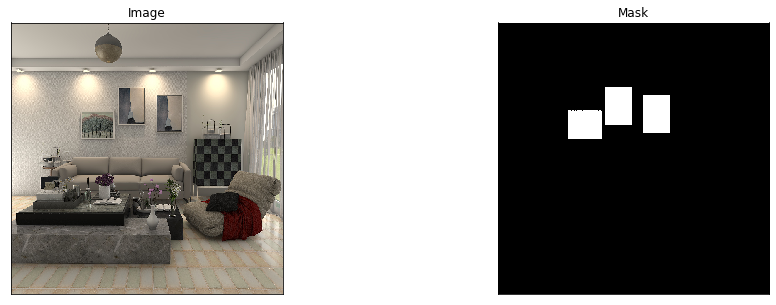

In [23]:
idmap_mask = modify_pixels(idmap, [(0, 64, 0), (64, 128, 128), (191, 128, 128)])
visualize(
    image=img, 
    mask=idmap_mask
)

You can also create a validation and a test set using the same method. 

### Nice but can we find a pattern in colors used in the idmap to detect frames?

Detecting the frame masks by manually finding the idmap colors representing the frames works but it is not very optimal. Let's try to find a pattern to automate this color detection. In other words, the question is: can we find some clusters of annotators?

In [24]:
from typing import List
import pandas as pd
from colormap import rgb2hex


def from_rgb_to_hex(rgb_colors):
    hex_colors = []
    for (occurences, rgb) in rgb_colors:
      hex_colors.append([rgb2hex(rgb[0], rgb[1], rgb[2]), occurences])
    return hex_colors


def extract_hex_colors(rgb_colors):
    hex_colors = []
    occurences_list = []
    for (occurences, rgb) in rgb_colors:
        hex_colors.append(rgb2hex(rgb[0], rgb[1], rgb[2]))
        occurences_list.append(occurences)
    return hex_colors, occurences_list

In [25]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

dict_colors = {}
colors_memory = []
occurences_memory = []
all_cols = []

for i in range(1000):
    path_idmap = list_idmap[i]

    idmap = Image.open(os.path.join(idmap_dir, path_idmap))
    all_colors = idmap.getcolors(idmap.size[0]*idmap.size[1])
    all_colors_hex, all_occurences = extract_hex_colors(all_colors)
    all_cols = all_cols + all_colors_hex

    colors_memory.append(all_colors_hex)
    occurences_memory.append(all_occurences)

all_cols = set(all_cols)
for col in all_cols:
    dict_colors[col] = []

for i in range(1000):
    current_colors = colors_memory[i]
    current_occurences = occurences_memory[i]
    for key, val in dict_colors.items():
        if key in current_colors:
            index = current_colors.index(key)
            dict_colors[key].append(current_occurences[index])
        else:
            dict_colors[key].append(0)

final_dict = pd.DataFrame(dict_colors)
final_dict.head(10)


#40BF80  #400000  #BF00DF  #408040  #809F80  #8040BF  #9F409F  #804000  \
0        0    85986        0        0        0        0        0     1968   
1        0   104246        0        0        0        0        0    19039   
2        0        0        0        0        0        0        0     1309   
3        0     1890        0        0        0        0        0        0   
4        0   178117        0        0        0        0        0     8777   
5        0    57784        0        0        0        0        0        0   
6        0        0        0        0        5        0        0        0   
7     1156    47472        0        0        0        0        0       30   
8        0        6        0        0        0     1871        0        6   
9      264     5675        0        0        0        6        0        0   

   #0040DF  #402020  ...  #9F0000  #000080  #00409F  #806080  #809FBF  \
0        0        0  ...        0   217420        0        0        0   
1        0        0  ...        0    45027        0        0        0   
2        0        0  ...        0    37560        0        0        0   
3        0        0  ...        0    61974        0        0        0   
4        0        0  ...        0   168427        0        0        0   
5        0        0  ...        0    91303        0        0        0   
6        0        0  ...        0        0        0        0        0   
7        0        0  ...        0       60        0        0        0   
8        0        0  ...        0        3        0        0        0   
9        0        0  ...        0    12464        0        0        0   

   #80209F  #9FDF80  #800000  #9F40BF  #00209F  
0        0        0     8021        0        0  
1        0        0     2064        0        0  
2        0        0        0        0        0  
3        0        0    86047        0        0  
4        0        0        0        0        0  
5        0        0        3        0        0  
6        0     2383        0     4648        0  
7        0        0        0        0        0  
8        0        0    75761        0        0  
9        0        0   121129        0        0  

[10 rows x 468 columns]

**Apply a dimensionamity reduction technique**

In order to be able to represent the data on a graph (in 2 dimensions), we need to find a way to reduce the number of dimensions that we currently have. To do that, let's use a well-known method called PCA.

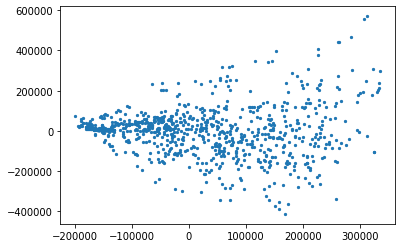

In [27]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Number of dimension that we need 
pca = PCA(2)
 
#Transform the data
#final_dict = StandardScaler().fit_transform(final_dict)
pca_array = pca.fit_transform(final_dict)

pca_df = pd.DataFrame({'X': pca_array[:, 0], 'Y': pca_array[:, 1]})

# Plot the data
plt.scatter(pca_array[:,0] , pca_array[:,1], s = 5)
plt.show()

**Apply a clustering algorithm**

Now that we have data in 2 dimensions, it's time to apply a clustering algorithm. In this case, we chose to use KMeans because it's a commonly used algorithm which is simple to understand. 

Nevertheless, this algorithm requires us to determine the number of clusters to find. At this point, we don't have any idea of how many clusters to define. In order to determine the optimal number of clusters to apply in the KMeans algorithm, let's apply the Elbow method.

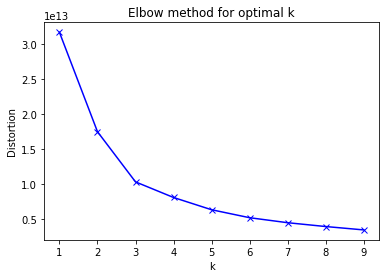

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(pca_array)
    distortions.append(model.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow method for optimal k')
plt.show()

Thanks to this method, we can conclude that the optimal number of clusters is 3. We can 

In [34]:
from sklearn.cluster import KMeans

number_clusters = 3

# Using sklearn
km = KMeans(n_clusters=number_clusters, random_state=0).fit(pca_array)

# Get cluster assignment labels
labels = km.labels_

# Format results as a DataFrame
final_dict["Cluster"] = labels
pca_df["Cluster"] = labels
final_dict.head(10)

#40BF80  #400000  #BF00DF  #408040  #809F80  #8040BF  #9F409F  #804000  \
0        0    85986        0        0        0        0        0     1968   
1        0   104246        0        0        0        0        0    19039   
2        0        0        0        0        0        0        0     1309   
3        0     1890        0        0        0        0        0        0   
4        0   178117        0        0        0        0        0     8777   
5        0    57784        0        0        0        0        0        0   
6        0        0        0        0        5        0        0        0   
7     1156    47472        0        0        0        0        0       30   
8        0        6        0        0        0     1871        0        6   
9      264     5675        0        0        0        6        0        0   

   #0040DF  #402020  ...  #000080  #00409F  #806080  #809FBF  #80209F  \
0        0        0  ...   217420        0        0        0        0   
1        0        0  ...    45027        0        0        0        0   
2        0        0  ...    37560        0        0        0        0   
3        0        0  ...    61974        0        0        0        0   
4        0        0  ...   168427        0        0        0        0   
5        0        0  ...    91303        0        0        0        0   
6        0        0  ...        0        0        0        0        0   
7        0        0  ...       60        0        0        0        0   
8        0        0  ...        3        0        0        0        0   
9        0        0  ...    12464        0        0        0        0   

   #9FDF80  #800000  #9F40BF  #00209F  Cluster  
0        0     8021        0        0        2  
1        0     2064        0        0        2  
2        0        0        0        0        2  
3        0    86047        0        0        0  
4        0        0        0        0        0  
5        0        3        0        0        0  
6     2383        0     4648        0        1  
7        0        0        0        0        2  
8        0    75761        0        0        1  
9        0   121129        0        0        1  

[10 rows x 469 columns]

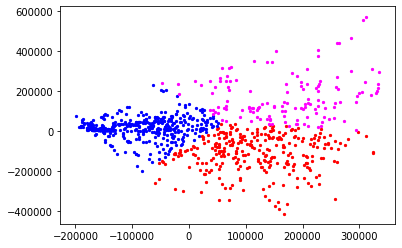

In [35]:
# Show the clustering on a graph

colors = ["red", "blue", "magenta", "cyan", "green", "grey"]
for i in range(number_clusters):
    current_df = pca_df[pca_df["Cluster"] == i]
    X_val = current_df["X"].values
    Y_val = current_df["Y"].values
    plt.scatter(X_val , Y_val, color=colors[i], s=5)

plt.show()

## 2.5 Solution 3: create the data set automatically using OpenCV

In [ ]:
import os
set_type = "train"

images_dir = os.path.join(DATA_DIR, set_type + '/image')
idmap_dir = os.path.join(DATA_DIR, set_type + '/idmap')

list_elem = os.listdir(images_dir) 
number_files = len(list_elem)
print(f"Number of files in the images folder: {number_files}")

list_idmap = os.listdir(idmap_dir) 
number_files = len(list_idmap)
print(f"Number of files in the idmap folder: {number_files}")

Number of files in the images folder: 14761
Number of files in the idmap folder: 14761


In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()


def find_mask(img):
    count = 0
    new_img = np.zeros(img.shape).astype(img.dtype)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(img,100,200)
    kernal = np.ones((2,2),np.uint8)
    dilation = cv2.dilate(edges, kernal , iterations=2)
    bilateral = cv2.bilateralFilter(dilation,9,75,75)
    contours, hireracy = cv2.findContours(bilateral,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for i,contour in enumerate(contours):
        approx = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour,True),True)   
        if len(approx) == 4:

            X,Y,W,H = cv2.boundingRect(approx)
            area = cv2.contourArea(contour)

            # Keep only rectangles of more than 4000 pixels to avoid very small ones
            if area > 4000 :
                count += 1
                box = cv2.rectangle(img, (X,Y), (X+W,Y+H), (0,0,255), 2)
                cropped = img[Y: Y+H, X: X+W]
                cv2.drawContours(new_img, [approx], 0, (255,255,255),1)
                cv2.fillPoly(new_img, pts =[approx], color=(255,255,255))

    return new_img, count

### Let's look at an example

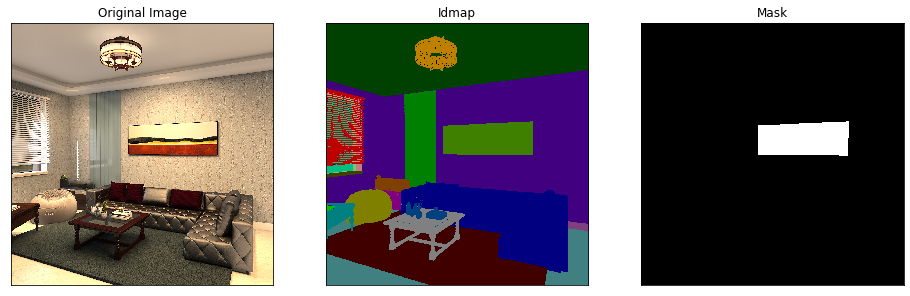

In [ ]:
index = 4

path_image = list_elem[index]
path_idmap = list_idmap[index]

original_img = Image.open(os.path.join(images_dir, path_image))
idmap = Image.open(os.path.join(idmap_dir, path_idmap))

img, count = find_mask(np.asarray(idmap))
visualize(
    original_image=original_img,
    idmap=idmap,
    mask=img
)

### Let's automate the creation of mask to build the new dataset

In [ ]:
from PIL import Image
import numpy as np
import os
import numpy as np

for i in range(10):
    if i%100 == 0:
        print(f"Image {i} currently managed")
    path_image = list_elem[i]
    path_idmap = list_idmap[i]

    original_img = Image.open(os.path.join(images_dir, path_image))
    idmap = Image.open(os.path.join(idmap_dir, path_idmap))

    img, count = find_mask(np.asarray(idmap))
    if count > 0:
        mask = Image.fromarray(img)

        save_path_mask = f'./mask_frames/{path_image}'
        save_path_img = f'./images_frames/{path_image}'
        
        mask.save(save_path_mask)
        original_img.save(save_path_img)

# 3 Train the new image segmentation model

In this section, we will train a new image segmentation model using the data that was created in the previous section. The goal is to build an image segmentation model capable of detecting frames on a picture and creating a mask of these frames.

In [4]:
!pip install -q -U segmentation-models

In [6]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


## 3.1 Create and compile the image segmentation model

In this section, we will define the image segmentation model and compile it so that it's ready to be trained. Note that the building and compilation of the model is done on the GPU device in order to be able to train this model using the GPU later. 

Feel free to modify anything you want. 

In [7]:
from PIL import Image
import tensorflow as tf
import os

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

# Set parameters
BACKBONE = 'resnet50' 
LR = 0.0001
CLASSES = ['frame']

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create image segmentation model
with tf.device(device_name):
  model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

  # define optomizer
  optim = tf.keras.optimizers.Adam(LR)

  # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
  total_loss = dice_loss + (1 * focal_loss)

  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

  # compile keras model with defined optimozer, loss and metrics
  model.compile(optim, total_loss, metrics)

env: SM_FRAMEWORK=tf.keras
94593024/94592056 [==============================] - 9s 0us/step


## 3.2 Prepare the data to train the model

The goal of this section is to create dataloaders for both the training and validation sets. These dataloaders will then be given as input of the training of the model. 

Both the Dataset and Dataloader functions are implemented in a python file that can be found at the following location: 
*workshop-image-segmentation-style-transfer/scripts/dataloader.py*

Feel free to modify this file!

In [9]:
!mv workshop-image-segmentation-style-transfer/scripts/dataloader.py ./

In [6]:
from dataloader import *

AMOUNT_IMG = 1000
IMG_SIZE = 640
BATCH_SIZE = 8

x_train_dir = os.path.join(DATA_DIR, 'train/image_frames')
y_train_dir = os.path.join(DATA_DIR, 'train/mask_frames')
x_valid_dir = os.path.join(DATA_DIR, 'validation/image_frames')
y_valid_dir = os.path.join(DATA_DIR, 'validation/mask_frames')

# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(IMG_SIZE),
    preprocessing=get_preprocessing(preprocess_input),
)

train_width, train_length,_ = train_dataset[0][0].shape
train_dataset.set_resize(train_width-train_width%32,train_length-train_length%32)
train_dataset.limit_data(AMOUNT_IMG*9//10)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(IMG_SIZE),
    preprocessing=get_preprocessing(preprocess_input),
)

valid_width, valid_length,_ = valid_dataset[0][0].shape
valid_dataset.set_resize(valid_width-valid_width%32,valid_length-valid_length%32)
valid_dataset.limit_data(AMOUNT_IMG//10)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)


Unrecognized authentication type: None


## 3.3 Train the model 

It's time to train the model! 

Small reminder: it takes approximately 3 minutes to run each epoch on the GPU device.

In [7]:
EPOCHS = 5

# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader)
)

history.history

Epoch 1/5
112/112 [==============================] - 347s 3s/step - loss: 0.8610 - iou_score: 0.2978 - f1-score: 0.4158 - val_loss: 0.8761 - val_iou_score: 0.3236 - val_f1-score: 0.4296
Epoch 2/5
112/112 [==============================] - 162s 1s/step - loss: 0.8420 - iou_score: 0.4558 - f1-score: 0.5620 - val_loss: 0.8616 - val_iou_score: 0.4986 - val_f1-score: 0.5592
Epoch 3/5
112/112 [==============================] - 165s 1s/step - loss: 0.8409 - iou_score: 0.4785 - f1-score: 0.5798 - val_loss: 0.8605 - val_iou_score: 0.5121 - val_f1-score: 0.5676
Epoch 4/5
112/112 [==============================] - 166s 1s/step - loss: 0.8377 - iou_score: 0.4892 - f1-score: 0.5865 - val_loss: 0.8622 - val_iou_score: 0.4923 - val_f1-score: 0.5601
Epoch 5/5
112/112 [==============================] - 162s 1s/step - loss: 0.8354 - iou_score: 0.5360 - f1-score: 0.6204 - val_loss: 0.8597 - val_iou_score: 0.5493 - val_f1-score: 0.5973


{'f1-score': [0.41579270362854004,
  0.5619791746139526,
  0.5797720551490784,
  0.5865064859390259,
  0.6203833818435669],
 'iou_score': [0.29781070351600647,
  0.4557981789112091,
  0.4785037636756897,
  0.4891803562641144,
  0.5360414385795593],
 'loss': [0.8610429763793945,
  0.8420117497444153,
  0.8409299254417419,
  0.8376933932304382,
  0.8354004621505737],
 'val_f1-score': [0.4296213984489441,
  0.5591627359390259,
  0.5675918459892273,
  0.560086190700531,
  0.5973474383354187],
 'val_iou_score': [0.3235813081264496,
  0.498623251914978,
  0.5121349096298218,
  0.4922924339771271,
  0.5493236780166626],
 'val_loss': [0.8761112093925476,
  0.8616313338279724,
  0.8605213761329651,
  0.8622255921363831,
  0.8597092628479004]}

## 3.4 Save the model 

In [10]:
save_path = "model_saved.h5"
model.save(save_path)

## 3.5 Check if the model performs well on a test data

In order to evaluate the performance of the model that we trained in the previous section, we will use an unseen image and try to predict the mask of the frame on this image.

In [11]:
import matplotlib.pyplot as plt
import cv2 
import numpy as np

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='gray')
    plt.show()

def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [13]:
index = 0

images_dir = os.path.join(DATA_DIR, 'test/image_frames')
list_elem = os.listdir(images_dir) 
path_image = list_elem[index]

original_img = Image.open(os.path.join(DATA_DIR + "/test/image_frames", path_image))
mask = Image.open(os.path.join(DATA_DIR + "/test/mask_frames", path_image.replace(".jpg", ".png")))

image = cv2.resize(np.array(original_img),(1184,1184), interpolation=cv2.INTER_CUBIC)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

test_image = np.expand_dims(image, axis=0)

The following cell loads the model that was trained in the previous section and predicts the mask for the chosen test image.

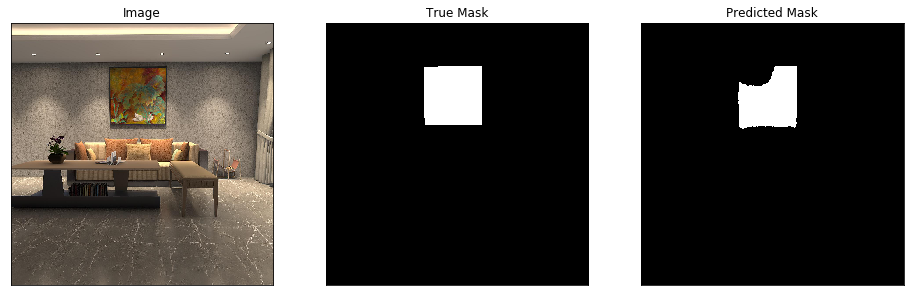

In [12]:
from tensorflow.keras.models import load_model
reconstructed_model = load_model("model_saved.h5", compile=False)

# Evaluate model performance on test set
pred = reconstructed_model.predict(test_image).round()
    
visualize(
        image=original_img,
        true_mask=mask,
        predicted_mask=pred[..., 0].squeeze(),
)

# <span style="color:orange">Style transfer - Exercise </span>

In the previous chapter, you learnt how to create and train an image segmentation model in order to detect frames on a picture. The goal of this second chapter of the exercise session is to learn how to apply a new style to the frame that you detected previously. 

It's time to show your creativity!


# 1 Choose the image to custom

The image to be customized shows a meeting room at the dataroots office. This image was stored in Azure so that you can access it easily. 


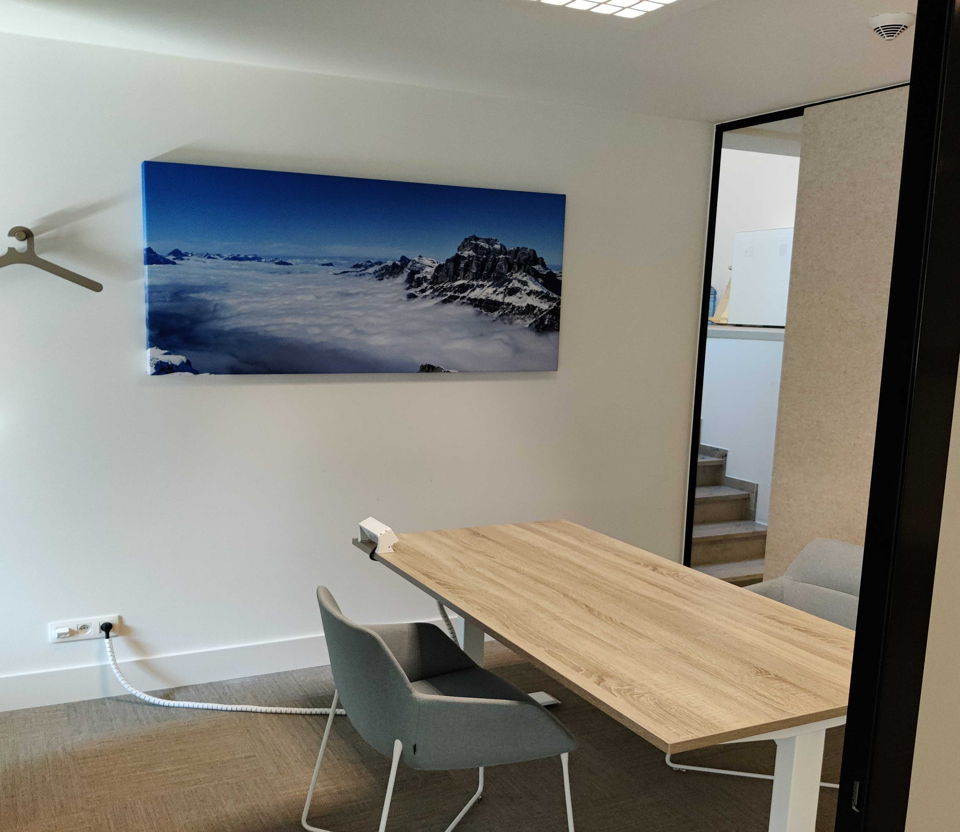

In [14]:
from PIL import Image
import os
import numpy as np
from IPython.display import display

image_to_custom = os.path.join(DATA_DIR, 'examples/image_to_custom.jpg')

img = Image.open(image_to_custom)
width, height = img.size
idx = np.argmin([width,height])

if idx==0:
  top= (height-width)//2
  bottom= height-(height-width)//2
  left = 0
  right= width
else:
  left = (width-height)//2
  right = width - (width-height)//2
  top = 0
  bottom = height

newsize = (960, 832)
new_img = img.crop((left, top, right, bottom))
new_img = new_img.resize(newsize)

new_img.save(f"image_to_custom.jpg")
display(new_img)

# 2 Choose the pattern to apply to the image

It's now time to choose the pattern that you want to apply to the frame. You can either load a pattern that is already stored in Azure (but there are only 4 possibilites) or you can upload your own pattern locally.

## Load pattern from Azure

In [ ]:
# Get style example from Azure 
import os
from PIL import Image

styles = {
    "multi-color": "examples/multicolor_pattern.jpeg",
    "tiger": "examples/tiger_pattern.jpeg",
    "water": "examples/water_pattern.jpeg",
    "zebra": "examples/zebra_pattern.jpeg",
    "zebra-color": "zebra_color_pattern.jpeg"
}

pattern = "zebra-color"
style_path = os.path.join(DATA_DIR, styles[pattern])
img = Image.open(style_path)
img.save(f"{pattern}.jpg")

## Upload pattern locally

In [15]:
from google.colab import files

uploaded = files.upload()

style_path = list(uploaded.keys())[0]

Saving pattern.jpeg to pattern.jpeg


## Resize the pattern image chosen and display it

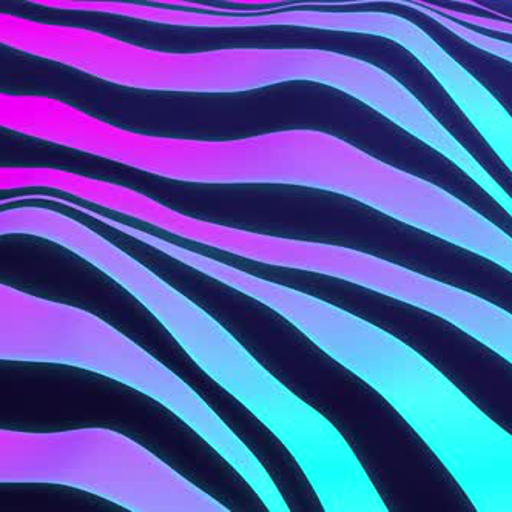

In [16]:
from PIL import Image
from IPython.display import display
import numpy as np

img = Image.open(style_path)
width, height = img.size
idx = np.argmin([width,height])

if idx==0:
  top= (height-width)//2
  bottom= height-(height-width)//2
  left = 0
  right= width
else:
  left = (width-height)//2
  right = width - (width-height)//2
  top = 0
  bottom = height

newsize = (512, 512)
im1 = img.crop((left, top, right, bottom))
im1 = im1.resize(newsize)
display(im1)

## Customize your pattern

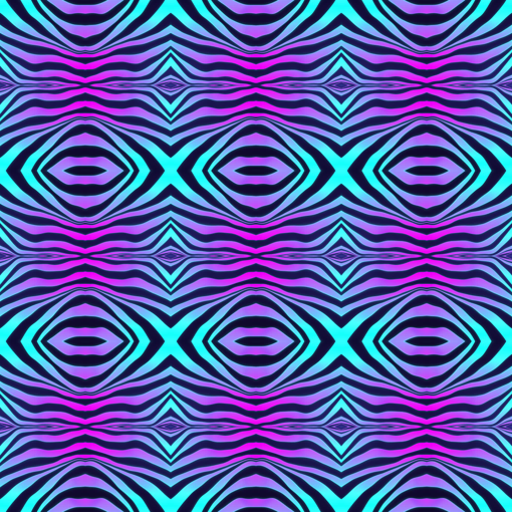

In [17]:
copies = 6
resize = (newsize[0]//copies,newsize[1]//copies)
dst = Image.new('RGB', (resize[0]*copies,resize[1]*copies))
im2 = im1.resize((resize))
for row in range(copies):
  im2 = im2.transpose(Image.FLIP_LEFT_RIGHT)
  for column in range(copies):
    im2 = im2.transpose(Image.FLIP_TOP_BOTTOM)
    dst.paste(im2, (resize[0]*row, resize[1]*column))
dst = dst.resize((newsize))
dst.save('./style_customized.jpg')
display(dst)

# 3 Apply the pattern on the entire image

The goal of this section is to apply the pattern to the entire picture.

In [18]:
!git clone https://github.com/diyiiyiii/StyTR-2.git

Cloning into 'StyTR-2'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 83 (delta 10), reused 9 (delta 9), pack-reused 69
Unpacking objects: 100% (83/83), done.


In [19]:
# Get pre-trained model from the cloud
import os 
vgg_path = os.path.join(DATA_DIR, "models/vgg_normalised.pth")
decoder_path = os.path.join(DATA_DIR, "models/decoder_iter_160000.pth")
transformer_path = os.path.join(DATA_DIR, "models/transformer_iter_160000.pth")
embedding_path = os.path.join(DATA_DIR, "models/embedding_iter_160000.pth")
uploaded_image = "image_to_custom.jpg"

In [20]:
!mv workshop-image-segmentation-style-transfer/scripts/apply_pattern.py StyTR-2/

In [21]:
!python StyTR-2/apply_pattern.py  --content $uploaded_image \
                  --style style_customized.jpg  \
                  --output  .\
                  --vgg $vgg_path \
                  --decoder_path $decoder_path \
                  --Trans_path $transformer_path \
                  --embedding_path $embedding_path

/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
image_to_custom.jpg
<class 'int'>
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


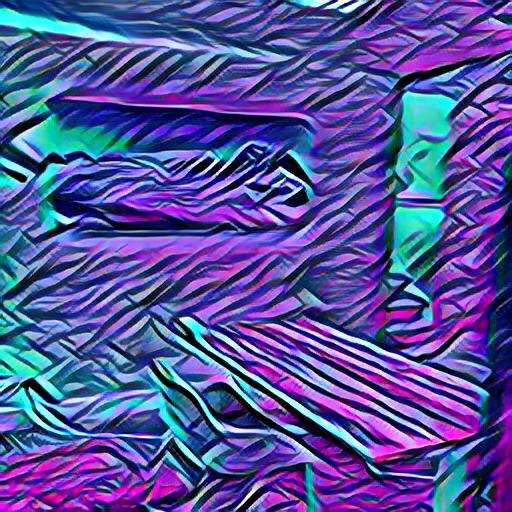

In [22]:
# Let's look at the styled image
from IPython.display import Image, display
path_styled_image = uploaded_image.split(".")[0] + "_stylized_style_customized.jpg"
display(Image(filename=path_styled_image))

# 4 Get final customized image

This is the final step of this exercise session. The goal is to get the final customized image. To get this, you will need to apply the style only to the frame we want to custom instead of applying it to the full picture.

## Get the mask of the object we want to custom 

In the previous chapter, you trained an image segmentation model. If this model gave you satisfying results, you can use it to predict the mask of the frame to customize. Otherwise, don't worry! You can load the actual mask of the frame from Azure. 

### Predict the mask using the image segmentation model that you trained

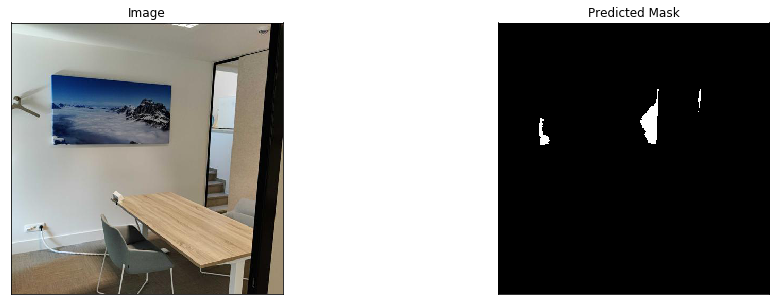

In [42]:
from tensorflow.keras.models import load_model
from PIL import Image

original_img = Image.open(uploaded_image)
image = cv2.resize(np.array(original_img),(1184,1184), interpolation=cv2.INTER_CUBIC)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

test_image = np.expand_dims(image, axis=0)

reconstructed_model = load_model("model_saved.h5", compile=False)

# Predict the mask using your model
mask = reconstructed_model.predict(test_image).round()
    
visualize(
        image=original_img,
        predicted_mask=mask[..., 0].squeeze(),
)

In [53]:
mask.save("mask.jpg")

### Get the actual mask from Azure

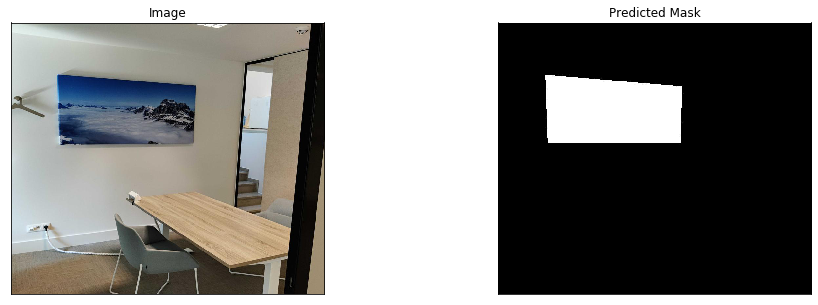

In [29]:
from PIL import Image

actual_mask = os.path.join(DATA_DIR, 'examples/actual_mask.jpg')

mask = Image.open(actual_mask)
visualize(
        image=original_img,
        predicted_mask=mask
)
mask.save("mask.jpg")

## Apply style only on the chosen object

The last step of this exercise session is to apply the new style only on the wallframe and not on the entire picture using the mask determined in the previous section.

In [30]:
content_image = "image_to_custom.jpg"
generated_image = "image_to_custom_stylized_style_customized.jpg"
content_mask = "mask.jpg"

In [31]:
import os
import numpy as np
import imageio
from PIL import Image as Img
from PIL import ImageTk

# util function to load masks
def load_mask(mask_path, shape):
    mask = imageio.imread(mask_path, pilmode="L") # Grayscale mask load
    width, height, _ = shape
    mask = np.array(Img.fromarray(mask).resize((width, height))).astype('float32')

    # Perform binarization of mask
    mask[mask <= 127] = 0
    mask[mask > 128] = 255

    max = np.amax(mask)
    mask /= max

    return mask


# util function to apply mask to generated image
def mask_content(content, generated, mask):
    width, height, channels = generated.shape

    for i in range(width):
        for j in range(height):
            if mask[i, j] == 0.:
                generated[i, j, :] = content[i, j, :]

    return generated

  
# util function to generate the final masked image
def save_final_masked(content_image, generated_image, content_mask):
  image_path = os.path.splitext(generated_image)[0] + "_masked.png"

  generated_image = imageio.imread(generated_image, pilmode="RGB")
  img_width, img_height, channels = generated_image.shape

  content_image = imageio.imread(content_image, pilmode='RGB')
  content_image = np.array(Img.fromarray(content_image).resize((img_width, img_height)))

  mask = load_mask(content_mask, generated_image.shape)

  img = mask_content(content_image, generated_image, mask)
  imageio.imwrite(image_path, img)

  return image_path


In [32]:
save_image_path = save_final_masked(content_image, generated_image, content_mask)
print("Image saved at path : %s" % save_image_path)

Image saved at path : image_to_custom_stylized_style_customized_masked.png


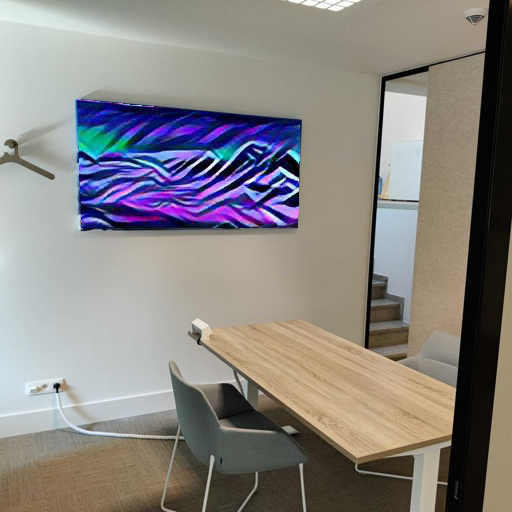

In [33]:
# Let's look at the final styled image
from IPython.display import Image, display
display(Image(filename="image_to_custom_stylized_style_customized_masked.png"))

**Satisfied with your customization? Present your result to the judges!**